### Convolutional Neural Networks

During this notebook a convolutional neural network will be trained to classify images of the CIFAR10 dataset.
This data set contains color images of 32 x 32 pixels of the following classes:

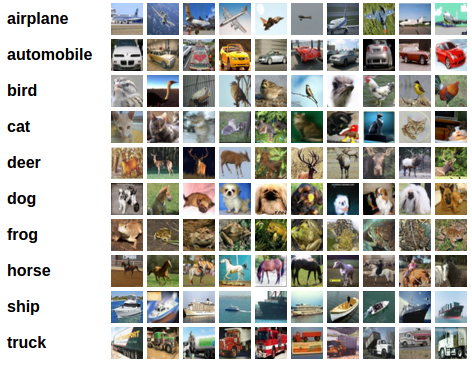

In [ ]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as transforms

In [ ]:
# Download the dataset

# Step 1. Acquire the data

dataset_url = "https://files.fast.ai/data/examples/cifar10.tgz"
download_url(dataset_url, './data')

In [ ]:
# Extract from archive
# The following command is used because the download is a .tgz file.

with tarfile.open('./data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
# As the information is in folders, we can use the ImageFolder class from
# torchvision to transform the data to tensors.

# test
#  -> airplane
#  -> automobile
#  ...

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

data_dir = './data/cifar10'

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

# Just to see how an image looks like
img, label = dataset[0]
print(img.shape, label) # As you can see the color channel is in the first position
# And matplot lib expects it in the last position.
img

print(dataset.classes)

In [ ]:
# To show an image:
import matplotlib.pyplot as plt

def show_image(img, label):
    print('Label:', dataset.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1,2,0))
    
show_image(img, label)

In [ ]:
# Training and validation set
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import numpy as np

batch_size=100

def split_indices(n, val_pct=0.1, seed=99): # n: size of the dataset, val_pct: percentage of data for validation set
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (this will help us to reproduce the same sets in the future)
    np.random.seed(seed)
    # Create a random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val] #training, validation

train_indices, val_indices = split_indices(len(dataset), val_pct=0.2, seed=42)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)


In this case two models are implemented. The first one has a lower complexity, since it only uses 16 filters and has fewer layers. The expected accuracy of this model is about 50%. 

The second model is more robust and an accuracy about 90% is to be expected

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Other model with nn.Sequential

model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1), # Out: batch_size x 16 x 32 x 32
    nn.ReLU(),
    nn.MaxPool2d(2,2), # batch_size x 16 x 16 x 16

    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # batch_size x 16 x 8 x 8

    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # batch_size x 16 x 4 x 4

    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # batch_size x 16 x 2 x 2

    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # batch_size x 16 x 1 x 1

    nn.Flatten(), #output batch_size x 16
    nn.Linear(16,10) #output: batch_size x 10
) 

model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(256*4*4, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [ ]:
# Use GPU

def get_default_device():
    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move Tensor(s) to chosen device
    if isinstance(data, (list, tuple)): # If it is a list or a tuple:
        # This will help us to transfer all our data to the device, even if we give a list or tuple.
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        # Number of batches
        return(len.dl)

In [ ]:
device=get_default_device()
print(device)

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Step 2. Generate predictions
    preds = model(xb)
    # Step 3. Calculate loss
    loss = loss_func(preds, yb)
    
    # Step 4. Optimize
    if opt is not None:
        # Compute gradients
        loss.backward()
        #Update parameters
        opt.step()
        #Reset gradients
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        #Compute the metric
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        
        #Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric=None
        if metric is not None:
            avg_metric=np.sum(np.multiply(metrics, nums)) / total
        return avg_loss, total, avg_metric

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds==labels).item() / len(preds)

def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, opt_fn=None, metric=None):
    train_losses, val_losses, metrics = [], [], []
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn,valid_dl, metric)
        val_loss, total, val_metric = result
        # Record the loss and metric
        train_losses.append(loss)
        val_losses.append(val_loss)
        metrics.append(val_metric)
        
        # Print the progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))       
        
    return train_losses, val_losses, metrics

In [ ]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.01

val, _, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)

history = fit(num_epochs, lr, model, F.cross_entropy, train_dl, valid_dl, opt_fn, accuracy)

train_losses, val_losses, val_metrics = history

In [ ]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
plot_metric([0] + val_metrics)

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs No. of epochs')
    
plot_losses([None]+train_losses, [2]+val_losses)

In [ ]:
# Prdiction of one image
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

img, label = test_dataset[1003]
plt.imshow(img.permute(1,2,0))
print('Label: {}, predicted: {}'.format(dataset.classes[label],predict_image(img, model)))


In [ ]:
# Test the hole set

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)

test_loss, _, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))